# Noise2Void - 2D Example for BSD68 Data

The data used in this notebook is the same as presented in the paper.

In [1]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
from model import nets
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

Using TensorFlow backend.


# Training Data Preparation

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')

# check if data has been downloaded already
zipPath="data/BSD68_reproducibility.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://cloud.mpi-cbg.de/index.php/s/pbj89sV6n6SyM29/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

In [4]:
X = np.load('data/BSD68_reproducibility_data/train/DCNN400_train_gaussian25.npy')
X_val = np.load('data/BSD68_reproducibility_data/val/DCNN400_validation_gaussian25.npy')

# Adding channel dimension
X = X[..., np.newaxis]
print(X.shape)
X_val = X_val[..., np.newaxis]
print(X_val.shape)


(3168, 180, 180, 1)
(4, 180, 180, 1)


In [5]:
# IMPORTANT!! I add clip
X = np.clip(X, 0, 255.)
X_val = np.clip(X_val, 0, 255.)

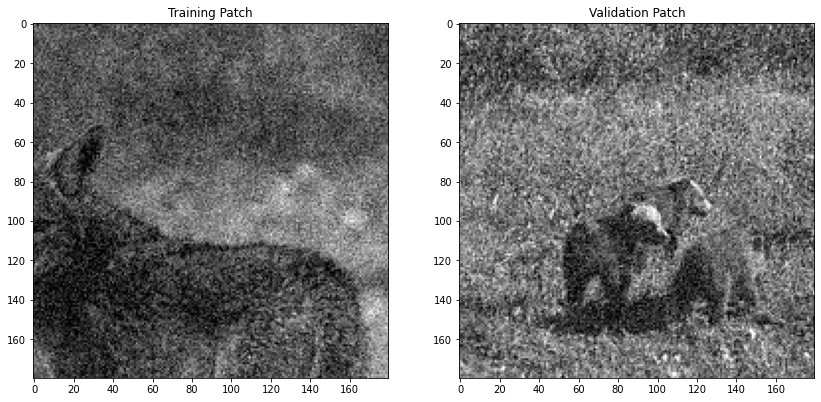

In [6]:
# Let's look at one of our training and validation patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...,0], cmap='gray')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...,0], cmap='gray')
plt.title('Validation Patch');

# Configure

In [7]:
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=24, train_epochs=3333, train_loss='mse', batch_norm=True, #GC: 200-> 16
                   train_batch_size=128, n2v_perc_pix=0.198, n2v_patch_shape=(64, 64), 
                   unet_n_first = 96,
                   unet_residual = True,
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=2)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['110.74583170793285'],
 'stds': ['62.335732441167494'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 96,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 3333,
 'train_steps_per_epoch': 24,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 150},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 2,
 'probabilistic': False}

In [8]:
# a name used to identify the model
model_name = 'BSD_test'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)
model.prepare_for_training(metrics=())

/home/qiang/Documents/codefiles/low_level/denoise/n2v/n2v/models/n2v_standard.py:418: UserWarning: output path for model already exists, files may be overwritten: /home/qiang/Documents/codefiles/low_level/denoise/n2v/examples/2D/denoising2D_BSD68/models/BSD_test
  'output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


# Training

Training the model will likely take some time. We recommend to monitor the progress with TensorBoard, which allows you to inspect the losses during training. Furthermore, you can look at the predictions for some of the validation images, which can be helpful to recognize problems early on.

You can start TensorBoard in a terminal from the current working directory with tensorboard --logdir=. Then connect to http://localhost:6006/ with your browser.

In [ ]:
# We are ready to start training now.
history = model.train(X, X_val)

/home/qiang/Documents/codefiles/low_level/denoise/n2v/n2v/models/n2v_standard.py:177: UserWarning: small number of validation images (only 0.1% of all images)
  warnings.warn("small number of validation images (only %.1f%% of all images)" % (100 * frac_val))
Preparing validation data: 100%|██████████| 4/4 [00:00<00:00, 180.30it/s]

8 blind-spots will be generated per training patch of size (64, 64).


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/3333
25/25 [==============================] - 13s 501ms/step - loss: 0.4798 - val_loss: 0.7938
Epoch 2/3333
25/25 [==============================] - 6s 236ms/step - loss: 0.2392 - val_loss: 0.4077
Epoch 3/3333
25/25 [==============================] - 6s 238ms/step - loss: 0.2235 - val_loss: 0.3069
Epoch 4/3333
25/25 [==============================] - 6s 236ms/step - loss: 0.2187 - val_loss: 0.2800
Epoch 5/3333
25/25 [==============================] - 6s 236ms/step - loss: 0.2183 - val_loss: 0.2866
Epoch 6/3333
25/25 [==============================] - 6s 240ms/step - loss: 0.2204 - val_loss: 0.2400
Epoch 7/3333
25/25 [

### After training, lets plot training and validation loss.

In [ ]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

# Compute PSNR to GT

In [ ]:
groundtruth_data = np.load('data/BSD68_reproducibility_data/test/bsd68_groundtruth.npy', allow_pickle=True)

In [ ]:
test_data = np.load('data/BSD68_reproducibility_data/test/bsd68_gaussian25.npy', allow_pickle=True)

In [ ]:
def PSNR(gt, img):
    mse = np.mean(np.square(gt - img))
    return 20 * np.log10(255) - 10 * np.log10(mse)

In [ ]:
# Weights corresponding to the smallest validation loss
# Smallest validation loss does not necessarily correspond to best performance, 
# because the loss is computed to noisy target pixels.
model.load_weights('weights_best.h5')

In [ ]:
pred = []
psnrs = []
for gt, img in zip(groundtruth_data, test_data):
    img = np.clip(img, 0, 255.) # add. 
    p_ = model.predict(img.astype(np.float32), 'YX');
    p_ = np.clip(p_, 0, 255.) # add.
    pred.append(p_)
    psnrs.append(PSNR(gt, p_))

psnrs = np.array(psnrs)

In [ ]:
print("PSNR:", np.round(np.mean(psnrs), 2))

In [ ]:
# % show images.
pred = []
psnrs = []
for gt, img in zip(groundtruth_data, test_data):
    img = np.clip(img, 0, 255.) # add. 
    
    p_ = model.predict(img.astype(np.float32), 'YX')
    
    p_ = np.clip(p_, 0, 255.) # add.
    
    pred.append(p_)
    psnrs.append(PSNR(gt, p_))
    
    plt.figure(figsize=(20,20))
    # We show the noisy input...
    plt.subplot(1,3,1)
    plt.imshow(img[:, :], cmap='gray')
    plt.title('Input');

    # and the result.
    plt.subplot(1,3,2)
    plt.imshow( p_[:, :], cmap='gray')
    plt.title('Prediction');
    
    plt.subplot(1,3,3)
    plt.imshow( gt[:, :], cmap='gray')
    plt.title('GT');
    
    plt.show()
    print('psnr:', psnrs[-1])
psnrs = np.array(psnrs)

In [ ]:
# The weights of the converged network. 
model.load_weights('weights_last.h5')

In [ ]:
pred = []
psnrs = []
for gt, img in zip(groundtruth_data, test_data):
    p_ = model.predict(img.astype(np.float32), 'YX')
    pred.append(p_)
    psnrs.append(PSNR(gt, p_))
    
    
psnrs = np.array(psnrs)

In [ ]:
print("PSNR:", np.round(np.mean(psnrs), 2))

In [ ]:
# % show images.
pred = []
psnrs = []
for gt, img in zip(groundtruth_data, test_data):
    img = np.clip(img, 0, 255.) # add. 
    
    p_ = model.predict(img.astype(np.float32), 'YX')
    
    p_ = np.clip(p_, 0, 255.) # add.
    
    pred.append(p_)
    psnrs.append(PSNR(gt, p_))
    
    plt.figure(figsize=(20,20))
    # We show the noisy input...
    plt.subplot(1,3,1)
    plt.imshow(img[:, :], cmap='gray')
    plt.title('Input');

    # and the result.
    plt.subplot(1,3,2)
    plt.imshow( p_[:, :], cmap='gray')
    plt.title('Prediction');
    
    plt.subplot(1,3,3)
    plt.imshow( gt[:, :], cmap='gray')
    plt.title('GT');
    
    plt.show()
    print('psnr:', psnrs[-1])
psnrs = np.array(psnrs)

In [ ]:
print("PSNR:", np.round(np.mean(psnrs), 2))